# مشروع بناء نموذج تنبؤي لأمانة منطقة الجوف

## الرخص الانشائية
*الفكره*
تطوير نموذج تنبؤ زمني لتحليل بيانات إصدار الرخص الإنشائية وفق التوزيع الشهري والأسبوعي، بهدف استكشاف الأنماط الموسمية وفترات الذروة والركود في الطلب على الرخص.
يشمل المشروع سلسلة مهام متكاملة تبدأ بتجهيز البيانات وتنظيفها، مرورًا بالتحليل الاستكشافي وفهم الأنماط الزمنية، ثم بناء نموذج تنبؤي متعدد الأبعاد، وأخيرًا تفسير النتائج ونشرها لدعم اتخاذ القرار في التخطيط العمراني والاستثماري.

## 0. تنزيل المكتبات و البيانات

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib



In [2]:
df = pd.read_csv("Construction license data.csv")
df.head()

,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية
0,أمانة منطقة الجوف,بلدية جنوب سكاكا - قارا,بلدية جنوب سكاكا - قارا,2/28/24 12:00:00 AM,1/26/27 12:00:00 AM,5/8/24 6:16:42 PM,إضافة وتعديل مكونات رخصة بناء,سارية,منتهى,صك
1,أمانة منطقة الجوف,بلدية طبرجل,بلدية طبرجل,9/21/24 12:00:00 AM,8/20/27 12:00:00 AM,9/15/24 7:13:10 PM,إصدار رخصة تصحيح وضع مبنى قائم,سارية,منتهى,صك
2,أمانة منطقة الجوف,بلدية وسط سكاكا,بلدية وسط سكاكا,5/10/82 12:00:00 AM,5/12/25 12:00:00 AM,5/22/24 10:39:57 AM,إضافة وتعديل مكونات رخصة بناء,منتهية,منتهى,صك
3,أمانة منطقة الجوف,بلدية القريات,بلدية القريات,8/15/24 12:00:00 AM,7/15/27 12:00:00 AM,7/18/24 12:32:18 AM,إصدار رخصة بناء,سارية,منتهى,صك
4,أمانة منطقة الجوف,بلدية طبرجل,بلدية طبرجل,4/22/96 12:00:00 AM,3/22/99 12:00:00 AM,9/3/24 11:27:17 AM,إدخال رخصة انشائية قديمة,منتهية,منتهى,صك


## 1. تحليل البيانات الأستكشافي

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3786 entries, 0 to 3785
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   الأمانة                    3786 non-null   object
 1   البلدية                    3786 non-null   object
 2   البلدية التي درست الطلب    3785 non-null   object
 3   تاريخ اصدار الرخصة ميلادي  3786 non-null   object
 4   تاريخ نهاية الرخصة ميلادي  3786 non-null   object
 5   تاريخ تقديم الطلب          3786 non-null   object
 6   الغرض                      3786 non-null   object
 7   حالة الرخصة                3786 non-null   object
 8   حالة الطلب                 3786 non-null   object
 9   نوع سند الملكية            3786 non-null   object
dtypes: object(10)
memory usage: 295.9+ KB


### 1.1 تحويل فئات الخصائص 

In [4]:
df.columns

Index(['الأمانة', 'البلدية', 'البلدية التي درست الطلب',
       'تاريخ اصدار الرخصة ميلادي', 'تاريخ نهاية الرخصة ميلادي',
       'تاريخ تقديم الطلب', 'الغرض', 'حالة الرخصة', 'حالة الطلب',
       'نوع سند الملكية'],
      dtype='object')

In [5]:
for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' in col and 'هجري' not in col:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"Column '{col}' converted to datetime.")

C:\Users\USER\AppData\Local\Temp\ipykernel_3844\848563665.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


Column 'تاريخ اصدار الرخصة ميلادي' converted to datetime.
Column 'تاريخ نهاية الرخصة ميلادي' converted to datetime.


C:\Users\USER\AppData\Local\Temp\ipykernel_3844\848563665.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\USER\AppData\Local\Temp\ipykernel_3844\848563665.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


Column 'تاريخ تقديم الطلب' converted to datetime.


In [6]:
pd.set_option('display.max_columns', None)

In [7]:
df.sample()

,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية
3268,أمانة منطقة الجوف,بلدية طبرجل,بلدية طبرجل,1985-08-01,2025-09-22,2024-09-18 09:14:37,إضافة وتعديل مكونات رخصة بناء,سارية,منتهى,صك


### 1.2 التحقق من القيم المفقودة

In [8]:
for col in df.columns:
    if df[col].isnull().any():
        print(f"Column '{col}' has missing values.")
        print(df[col].isnull().sum(), "missing values")

Column 'البلدية التي درست الطلب' has missing values.
1 missing values


In [9]:
for col in df.columns:
    print(f"{col}: missing persentage is {df[col].isnull().sum() / len(df[col]) *100}%")

الأمانة: missing persentage is 0.0%
البلدية: missing persentage is 0.0%
البلدية التي درست الطلب: missing persentage is 0.02641310089804543%
تاريخ اصدار الرخصة ميلادي: missing persentage is 0.0%
تاريخ نهاية الرخصة ميلادي: missing persentage is 0.0%
تاريخ تقديم الطلب: missing persentage is 0.0%
الغرض: missing persentage is 0.0%
حالة الرخصة: missing persentage is 0.0%
حالة الطلب: missing persentage is 0.0%
نوع سند الملكية: missing persentage is 0.0%


### 1.3 تعويض القيم المفقودة

In [10]:
df['البلدية التي درست الطلب'] = df['البلدية التي درست الطلب'].fillna(df['البلدية'])


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3786 entries, 0 to 3785
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   الأمانة                    3786 non-null   object        
 1   البلدية                    3786 non-null   object        
 2   البلدية التي درست الطلب    3786 non-null   object        
 3   تاريخ اصدار الرخصة ميلادي  3786 non-null   datetime64[ns]
 4   تاريخ نهاية الرخصة ميلادي  3786 non-null   datetime64[ns]
 5   تاريخ تقديم الطلب          3786 non-null   datetime64[ns]
 6   الغرض                      3786 non-null   object        
 7   حالة الرخصة                3786 non-null   object        
 8   حالة الطلب                 3786 non-null   object        
 9   نوع سند الملكية            3786 non-null   object        
dtypes: datetime64[ns](3), object(7)
memory usage: 295.9+ KB


### 1.4 ماهو مدى البيانات

In [12]:
print(" Minimum date:", df['تاريخ تقديم الطلب'].min())
print(" Maximum date:", df['تاريخ تقديم الطلب'].max())

 Minimum date: 2024-01-01 09:13:02
 Maximum date: 2024-12-31 21:13:36


In [13]:
print("Minimum date:", df['تاريخ اصدار الرخصة ميلادي'].min())
print("Maximum date:", df['تاريخ اصدار الرخصة ميلادي'].max())

Minimum date: 1975-08-03 00:00:00
Maximum date: 2073-08-02 00:00:00


### 1.5 ماهي القيم داخل الأعمدة

In [14]:
for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' not in col:
        unique_values = df[col].unique()
        print(f"Column '{col}' has {len(unique_values)} unique values.")

Column 'الأمانة' has 1 unique values.
Column 'البلدية' has 12 unique values.
Column 'البلدية التي درست الطلب' has 12 unique values.
Column 'الغرض' has 12 unique values.
Column 'حالة الرخصة' has 4 unique values.
Column 'حالة الطلب' has 1 unique values.
Column 'نوع سند الملكية' has 3 unique values.


In [15]:
for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' not in col:
        values = df[col].value_counts()
        print(f"Column '{col}' value counts:")
        print(values)
        print("\n")


Column 'الأمانة' value counts:
الأمانة
أمانة منطقة الجوف    3786
Name: count, dtype: int64


Column 'البلدية' value counts:
البلدية
بلدية القريات              1099
بلدية دومة الجندل           618
بلدية وسط سكاكا             609
بلدية طبرجل                 500
بلدية شمال سكاكا            345
بلدية جنوب سكاكا - قارا     240
بلدية أبوعجرم               179
بلدية صوير                  102
بلدية العيساويه              45
بلدية زلوم                   45
الحديثة                       3
بلدية الناصفه                 1
Name: count, dtype: int64


Column 'البلدية التي درست الطلب' value counts:
البلدية التي درست الطلب
بلدية القريات              1099
بلدية دومة الجندل           618
بلدية وسط سكاكا             609
بلدية طبرجل                 500
بلدية شمال سكاكا            345
بلدية جنوب سكاكا - قارا     240
بلدية أبوعجرم               179
بلدية صوير                  102
بلدية العيساويه              45
بلدية زلوم                   45
الحديثة                       3
بلدية الناصفه                 1
N

## 2. تحليل البيانات 

### 2.1 مدة صلاحية الرخصة

In [16]:
df['مدة صلاحية الرخصة'] = df['تاريخ نهاية الرخصة ميلادي'] - df['تاريخ اصدار الرخصة ميلادي']
df['مدة صلاحية الرخصة'] =df['مدة صلاحية الرخصة'].dt.days / 30 / 12 
df['مدة صلاحية الرخصة'] = df['مدة صلاحية الرخصة'].round()

df['مدة صلاحية الرخصة'].unique()


array([  3.,  44.,  32.,   4.,   1.,   5.,  11.,  15.,  46.,  12.,   7.,
        14.,   6.,  18.,  16.,  49.,  24., -46.,  40.,   0.,  17.,  25.,
        41.,  10.,  43.,   9.,  31.,  13.,  47.,  36.,  28.,   8.,  19.,
        48.,  22.,  38.,  27.,  42.,  23.,  29.,  26.,  33.,  35.,  30.,
        45.,   2., -99.,  21.,  20.,  37.,  39., -49.])

In [17]:
negative_validity = df[df['مدة صلاحية الرخصة'] < 0]
negative_validity


,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية,مدة صلاحية الرخصة
123,أمانة منطقة الجوف,بلدية وسط سكاكا,بلدية وسط سكاكا,2071-03-27,2025-10-10,2024-10-08 09:47:24,إضافة وتعديل مكونات رخصة بناء,سارية,منتهى,صك,-46.0
1598,أمانة منطقة الجوف,بلدية جنوب سكاكا - قارا,بلدية جنوب سكاكا - قارا,2073-08-02,1976-07-01,2024-10-15 08:18:33,إدخال رخصة انشائية قديمة,ملغية,منتهى,صك,-99.0
3209,أمانة منطقة الجوف,بلدية القريات,بلدية القريات,2073-05-03,2024-08-29,2024-01-01 16:55:28,إضافة وتعديل مكونات رخصة بناء,منتهية,منتهى,صك,-49.0


In [18]:
df = df[df['مدة صلاحية الرخصة'] >= 0]


In [19]:
print("Minimum renewal period:", df['مدة صلاحية الرخصة'].min(), "years")
print("Maximum renewal period:", df['مدة صلاحية الرخصة'].max(), "years")

df['مدة صلاحية الرخصة'].describe()

Minimum renewal period: 0.0 years
Maximum renewal period: 49.0 years


count    3783.000000
mean        4.461274
std         6.474538
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max        49.000000
Name: مدة صلاحية الرخصة, dtype: float64

In [20]:
print('number of linceses has validity more than 10 years:', df[df['مدة صلاحية الرخصة'] > 40].shape[0])

number of linceses has validity more than 10 years: 47


Text(0.5, 0, 'Validity Period (Years)')

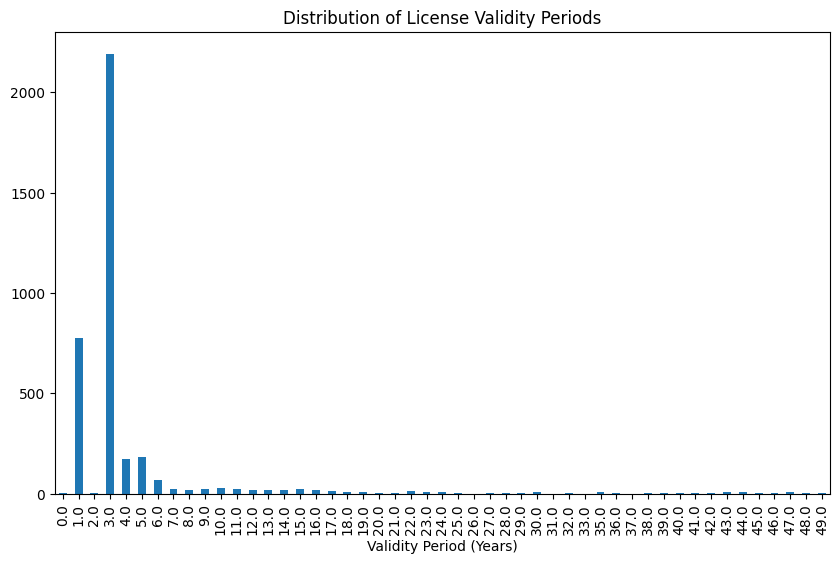

In [21]:

plt.figure(figsize=(10, 6)) 
df['مدة صلاحية الرخصة'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of License Validity Periods')
plt.xlabel('Validity Period (Years)')

#### 2.1.1 انشاء عمود فئة صلاحية الرخصة

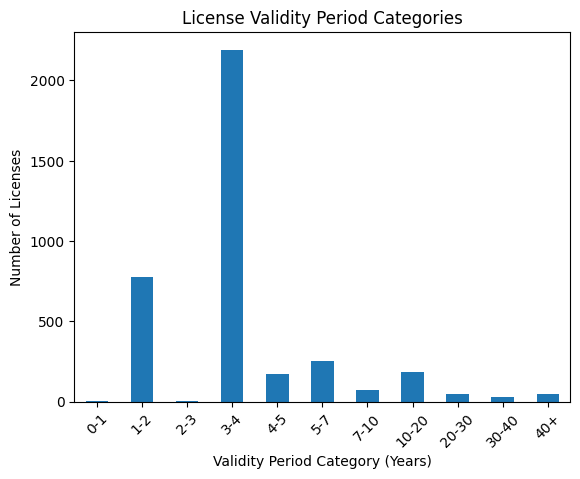

In [22]:
df['فئة مدة صلاحية الرخصة'] = pd.cut(
    df['مدة صلاحية الرخصة'],
    bins=[0, 1, 2, 3, 4, 5, 7, 10, 20, 30, 40, float('inf')],
    labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-7', '7-10', '10-20', '20-30', '30-40', '40+'],
    right=False
)
df['فئة مدة صلاحية الرخصة'].value_counts().sort_index().plot(kind='bar')
plt.title('License Validity Period Categories')
plt.xlabel('Validity Period Category (Years)')
plt.ylabel('Number of Licenses')
plt.xticks(rotation=45)
plt.show()
                                    

In [23]:
df['فئة مدة صلاحية الرخصة'] = df['فئة مدة صلاحية الرخصة'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3783 entries, 0 to 3785
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   الأمانة                    3783 non-null   object        
 1   البلدية                    3783 non-null   object        
 2   البلدية التي درست الطلب    3783 non-null   object        
 3   تاريخ اصدار الرخصة ميلادي  3783 non-null   datetime64[ns]
 4   تاريخ نهاية الرخصة ميلادي  3783 non-null   datetime64[ns]
 5   تاريخ تقديم الطلب          3783 non-null   datetime64[ns]
 6   الغرض                      3783 non-null   object        
 7   حالة الرخصة                3783 non-null   object        
 8   حالة الطلب                 3783 non-null   object        
 9   نوع سند الملكية            3783 non-null   object        
 10  مدة صلاحية الرخصة          3783 non-null   float64       
 11  فئة مدة صلاحية الرخصة      3783 non-null   object        
dtypes: datetime

### 2.2 تحليل تنوع القيم في الخصائص

In [24]:
df.columns

Index(['الأمانة', 'البلدية', 'البلدية التي درست الطلب',
       'تاريخ اصدار الرخصة ميلادي', 'تاريخ نهاية الرخصة ميلادي',
       'تاريخ تقديم الطلب', 'الغرض', 'حالة الرخصة', 'حالة الطلب',
       'نوع سند الملكية', 'مدة صلاحية الرخصة', 'فئة مدة صلاحية الرخصة'],
      dtype='object')

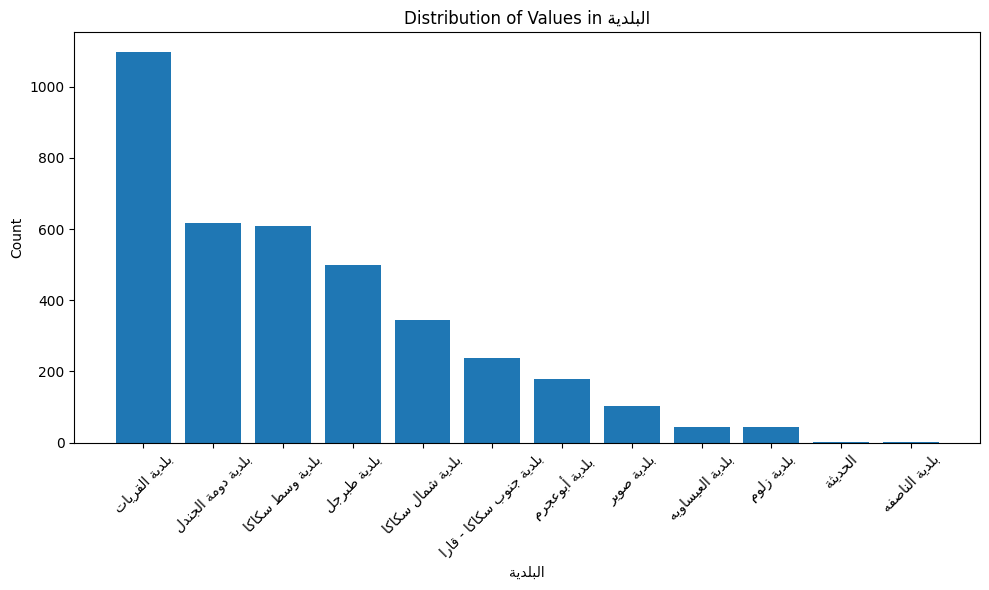

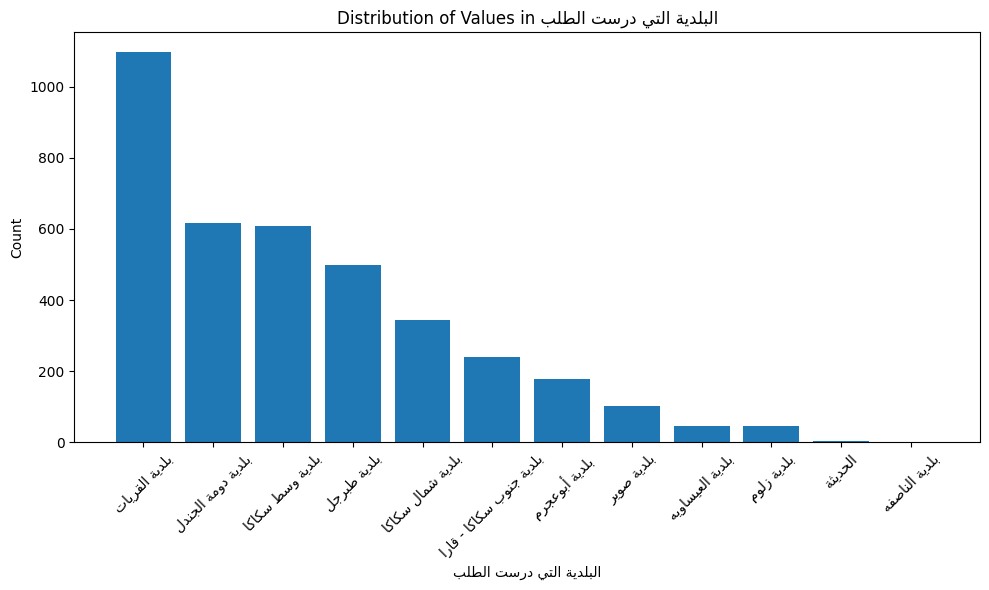

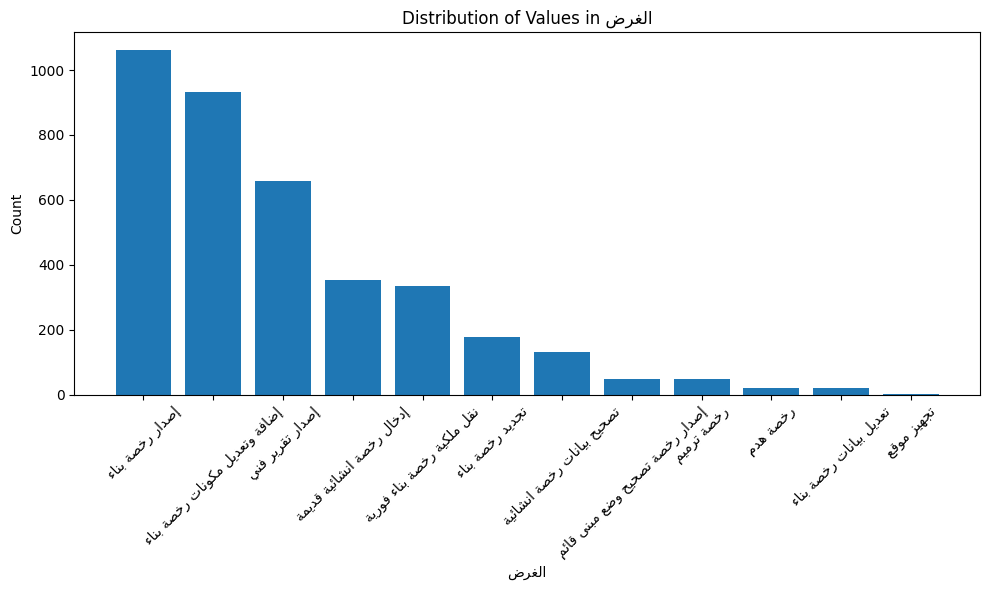

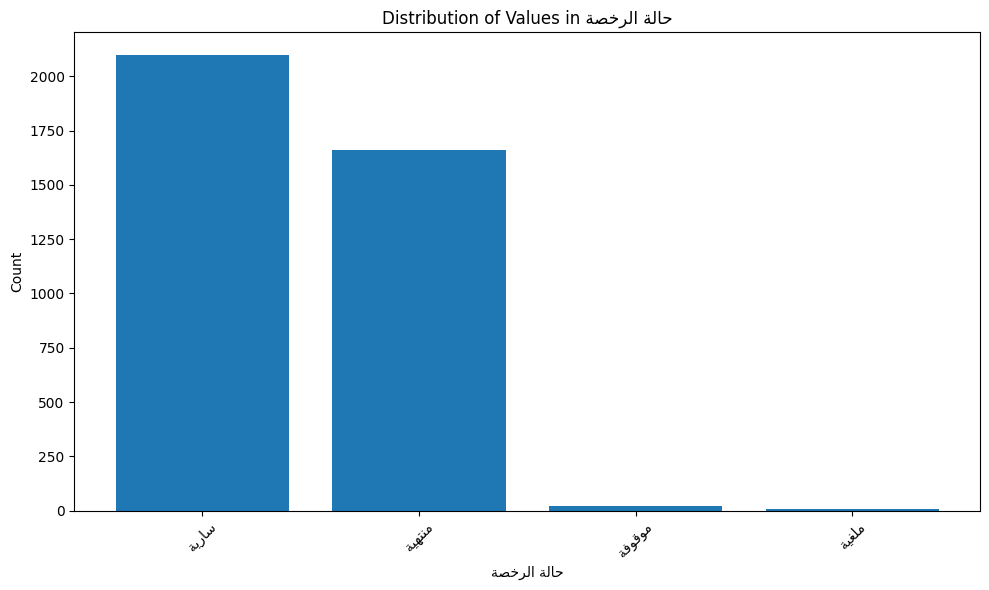

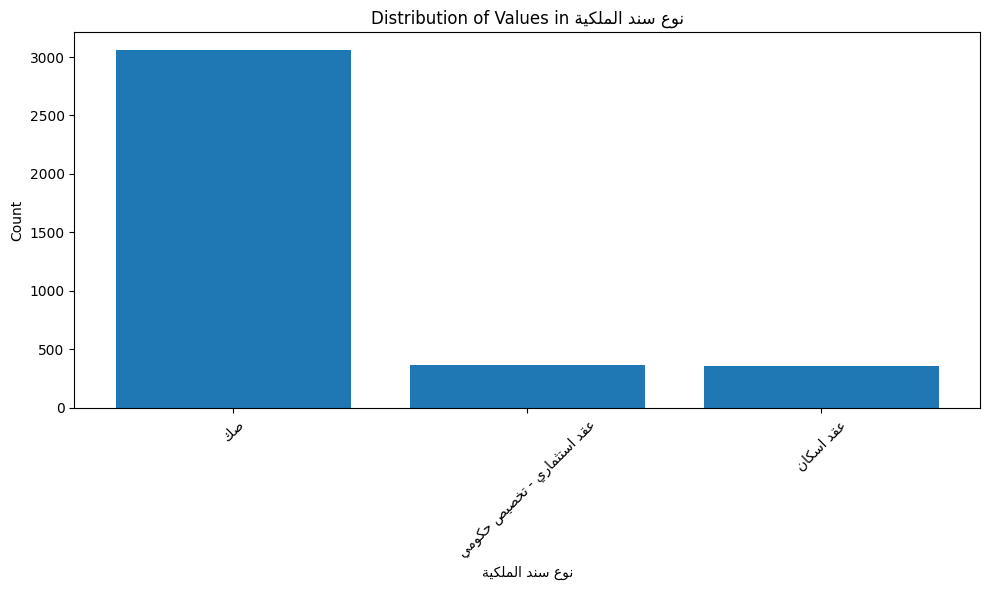

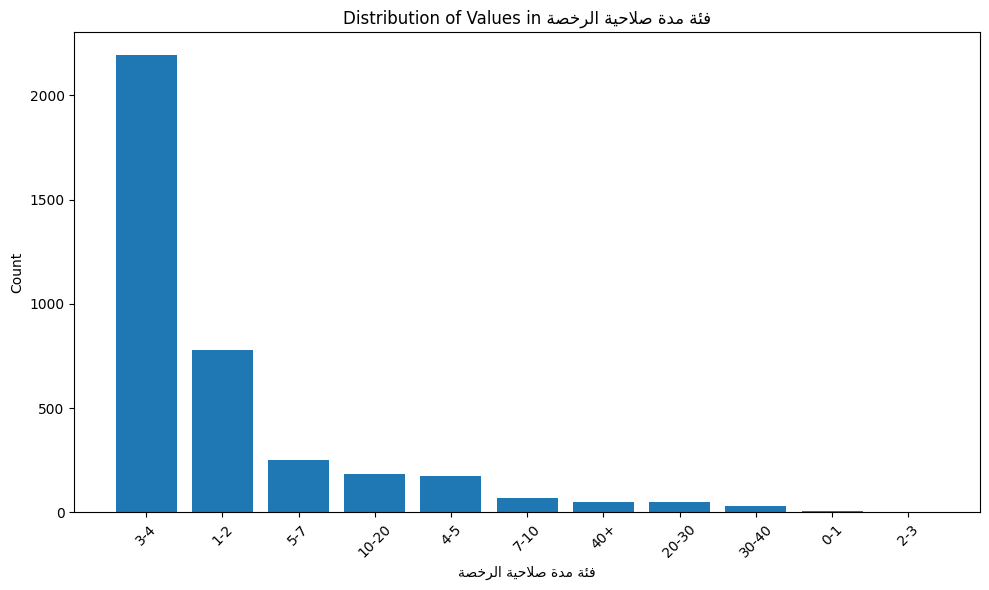

In [25]:

for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' not in col and df[col].nunique() > 1:
        value_counts = df[col].value_counts()
        
        if len(value_counts) < 20:
            reshaped_labels = [get_display(arabic_reshaper.reshape(str(label))) for label in value_counts.index]
            
            plt.figure(figsize=(10, 6))
            plt.bar(reshaped_labels, value_counts.values)
            
            reshaped_title = get_display(arabic_reshaper.reshape(col))
            plt.title(f'Distribution of Values in {reshaped_title}')
            plt.xlabel(reshaped_title)
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


In [26]:
df.columns

Index(['الأمانة', 'البلدية', 'البلدية التي درست الطلب',
       'تاريخ اصدار الرخصة ميلادي', 'تاريخ نهاية الرخصة ميلادي',
       'تاريخ تقديم الطلب', 'الغرض', 'حالة الرخصة', 'حالة الطلب',
       'نوع سند الملكية', 'مدة صلاحية الرخصة', 'فئة مدة صلاحية الرخصة'],
      dtype='object')

### 2.3 مصفوفه الارتباط

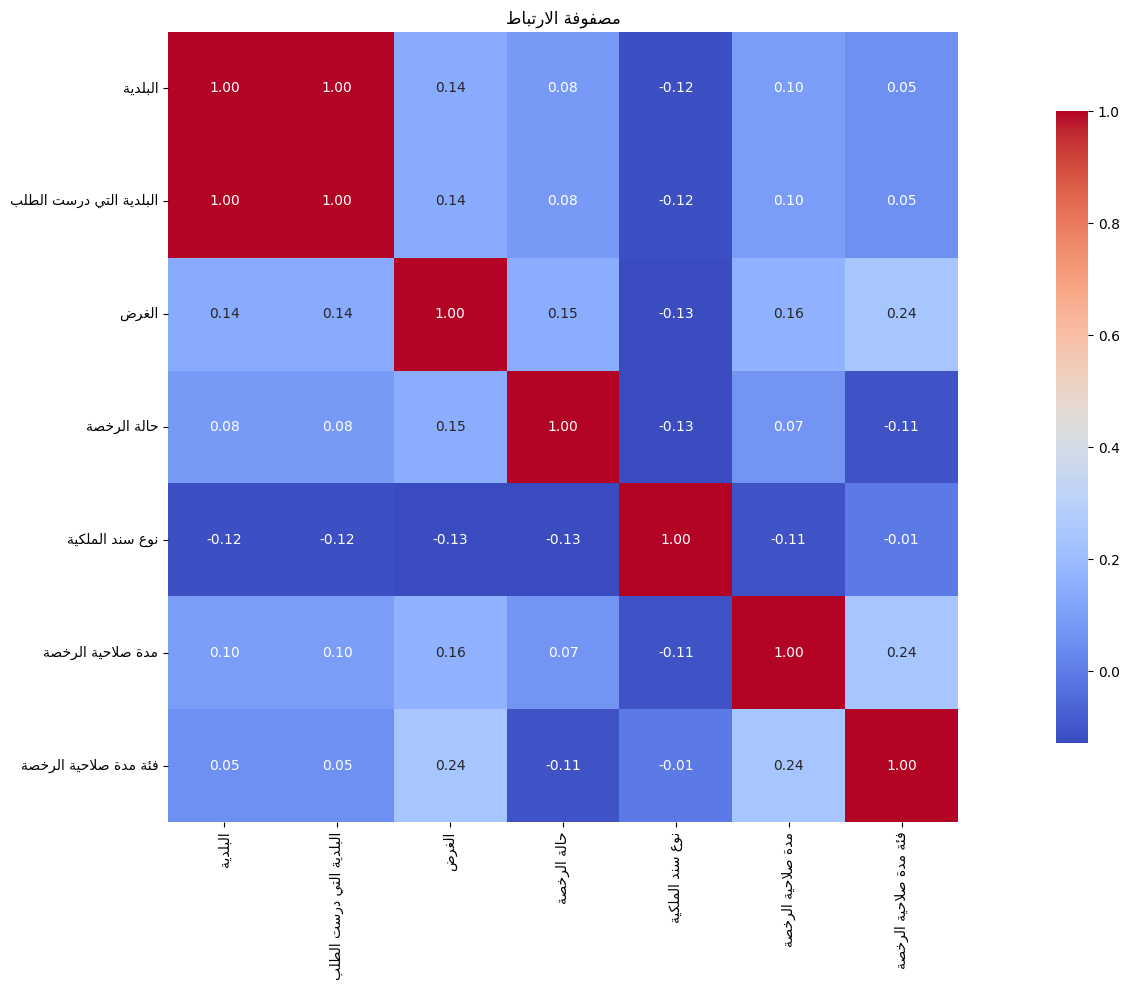

In [27]:


data = df.copy()
for col in data.columns:
    if data[col].dtype == 'object' and 'تاريخ' not in col and data[col].nunique() > 1:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))

corr_matrix = data.corr(numeric_only=True)

# corr_matrix = corr_matrix.iloc[1:, 1:]

reshaped_labels = [get_display(arabic_reshaper.reshape(str(label))) for label in corr_matrix.columns]
corr_matrix.columns = reshaped_labels
corr_matrix.index = reshaped_labels

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title(get_display(arabic_reshaper.reshape('مصفوفة الارتباط'))) 
plt.tight_layout()
plt.show()


In [28]:
df.sample()

,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية,مدة صلاحية الرخصة,فئة مدة صلاحية الرخصة
3542,أمانة منطقة الجوف,بلدية صوير,بلدية صوير,2022-11-09,2025-10-07,2024-11-26 11:55:31,تصحيح بيانات رخصة انشائية,سارية,منتهى,صك,3.0,3-4


In [29]:
data.sample()

,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية,مدة صلاحية الرخصة,فئة مدة صلاحية الرخصة
3757,أمانة منطقة الجوف,3,3,2024-10-10,2025-09-29,2024-10-08 13:04:31,1,0,منتهى,0,1.0,1


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3783 entries, 0 to 3785
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   الأمانة                    3783 non-null   object        
 1   البلدية                    3783 non-null   int64         
 2   البلدية التي درست الطلب    3783 non-null   int64         
 3   تاريخ اصدار الرخصة ميلادي  3783 non-null   datetime64[ns]
 4   تاريخ نهاية الرخصة ميلادي  3783 non-null   datetime64[ns]
 5   تاريخ تقديم الطلب          3783 non-null   datetime64[ns]
 6   الغرض                      3783 non-null   int64         
 7   حالة الرخصة                3783 non-null   int64         
 8   حالة الطلب                 3783 non-null   object        
 9   نوع سند الملكية            3783 non-null   int64         
 10  مدة صلاحية الرخصة          3783 non-null   float64       
 11  فئة مدة صلاحية الرخصة      3783 non-null   int64         
dtypes: datetime

توجد خصائص متشابهه

### 2.4 تحليل الارتباط التاريخي

In [31]:
for col in df.columns:
    if 'تاريخ' in col:
        print(col)

تاريخ اصدار الرخصة ميلادي
تاريخ نهاية الرخصة ميلادي
تاريخ تقديم الطلب


In [32]:
for col in df.columns:
    if 'تاريخ' in col and 'هجري' not in col:
        print(col)

تاريخ اصدار الرخصة ميلادي
تاريخ نهاية الرخصة ميلادي
تاريخ تقديم الطلب


In [33]:
df.columns

Index(['الأمانة', 'البلدية', 'البلدية التي درست الطلب',
       'تاريخ اصدار الرخصة ميلادي', 'تاريخ نهاية الرخصة ميلادي',
       'تاريخ تقديم الطلب', 'الغرض', 'حالة الرخصة', 'حالة الطلب',
       'نوع سند الملكية', 'مدة صلاحية الرخصة', 'فئة مدة صلاحية الرخصة'],
      dtype='object')

In [34]:
collection = ['البلدية','الغرض','نوع سند الملكية','فئة مدة صلاحية الرخصة']
for col in collection:
    # pass
    print(df[col].value_counts())
    print(f'{col}: {df[col].dtype}')


البلدية
بلدية القريات              1098
بلدية دومة الجندل           618
بلدية وسط سكاكا             608
بلدية طبرجل                 500
بلدية شمال سكاكا            345
بلدية جنوب سكاكا - قارا     239
بلدية أبوعجرم               179
بلدية صوير                  102
بلدية العيساويه              45
بلدية زلوم                   45
الحديثة                       3
بلدية الناصفه                 1
Name: count, dtype: int64
البلدية: object
الغرض
إصدار رخصة بناء                   1063
إضافة وتعديل مكونات رخصة بناء      932
إصدار تقرير فني                    657
إدخال رخصة انشائية قديمة           353
نقل ملكية رخصة بناء فورية          335
تجديد رخصة بناء                    178
تصحيح بيانات رخصة انشائية          130
إصدار رخصة تصحيح وضع مبنى قائم      47
رخصة ترميم                          47
رخصة هدم                            21
تعديل بيانات رخصة بناء              19
تجهيز موقع                           1
Name: count, dtype: int64
الغرض: object
نوع سند الملكية
صك                            3058
ع

In [35]:
weekday_map = {
    'Sunday': 'الأحد',
    'Monday': 'الإثنين',
    'Tuesday': 'الثلاثاء',
    'Wednesday': 'الأربعاء',
    'Thursday': 'الخميس',
    'Friday': 'الجمعة',
    'Saturday': 'السبت'
}

In [36]:
df['سنة الطلب'] = df['تاريخ تقديم الطلب'].dt.year
df['شهر الطلب'] = df['تاريخ تقديم الطلب'].dt.month
df['أسبوع الطلب'] = df['تاريخ تقديم الطلب'].dt.isocalendar().week
df['يوم الأسبوع'] = df['تاريخ تقديم الطلب'].dt.day_name().map(weekday_map)
df['يوم الطلب'] = df['تاريخ تقديم الطلب'].dt.day

In [37]:
df.sample()

,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية,مدة صلاحية الرخصة,فئة مدة صلاحية الرخصة,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الأسبوع,يوم الطلب
2002,أمانة منطقة الجوف,بلدية دومة الجندل,بلدية دومة الجندل,2024-01-23,2026-12-20,2024-01-22 20:00:04,إصدار رخصة بناء,سارية,منتهى,صك,3.0,3-4,2024,1,4,الإثنين,22


In [38]:
columns_needed = collection + ['تاريخ تقديم الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب', 'يوم الطلب', 'يوم الأسبوع']
dataframe = df[columns_needed]
dataframe.head()

,البلدية,الغرض,نوع سند الملكية,فئة مدة صلاحية الرخصة,تاريخ تقديم الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع
0,بلدية جنوب سكاكا - قارا,إضافة وتعديل مكونات رخصة بناء,صك,3-4,2024-05-08 18:16:42,2024,5,19,8,الأربعاء
1,بلدية طبرجل,إصدار رخصة تصحيح وضع مبنى قائم,صك,3-4,2024-09-15 19:13:10,2024,9,37,15,الأحد
2,بلدية وسط سكاكا,إضافة وتعديل مكونات رخصة بناء,صك,40+,2024-05-22 10:39:57,2024,5,21,22,الأربعاء
3,بلدية القريات,إصدار رخصة بناء,صك,3-4,2024-07-18 00:32:18,2024,7,29,18,الخميس
4,بلدية طبرجل,إدخال رخصة انشائية قديمة,صك,3-4,2024-09-03 11:27:17,2024,9,36,3,الثلاثاء


In [39]:
columns_needed

['البلدية',
 'الغرض',
 'نوع سند الملكية',
 'فئة مدة صلاحية الرخصة',
 'تاريخ تقديم الطلب',
 'سنة الطلب',
 'شهر الطلب',
 'أسبوع الطلب',
 'يوم الطلب',
 'يوم الأسبوع']

In [40]:
def reshape_arabic(text):
    return get_display(arabic_reshaper.reshape(text))

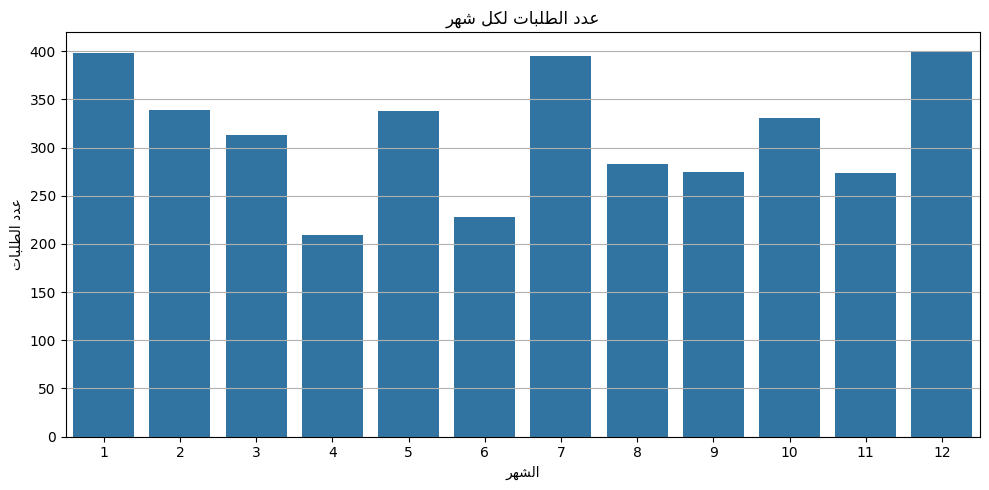

In [41]:
plt.figure(figsize=(10, 5))
sns.countplot(data=dataframe, x='شهر الطلب', order=sorted(dataframe['شهر الطلب'].unique()))
plt.title(reshape_arabic('عدد الطلبات لكل شهر'))
plt.xlabel(reshape_arabic('الشهر'))
plt.ylabel(reshape_arabic('عدد الطلبات'))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

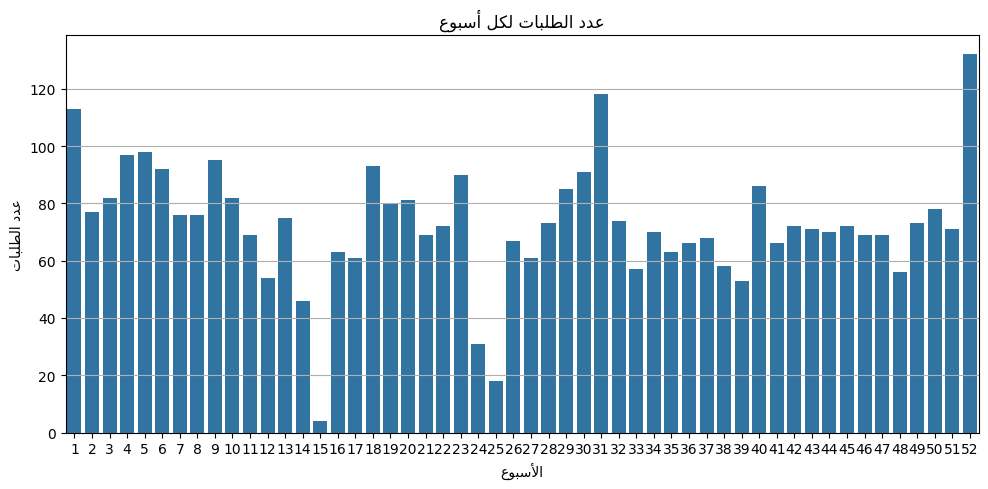

In [42]:
plt.figure(figsize=(10, 5))
sns.countplot(data=dataframe, x='أسبوع الطلب', order=sorted(dataframe['أسبوع الطلب'].unique()))
plt.title(reshape_arabic('عدد الطلبات لكل أسبوع'))
plt.xlabel(reshape_arabic('الأسبوع'))
plt.ylabel(reshape_arabic('عدد الطلبات'))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [43]:
dataframe.columns

Index(['البلدية', 'الغرض', 'نوع سند الملكية', 'فئة مدة صلاحية الرخصة',
       'تاريخ تقديم الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب',
       'يوم الطلب', 'يوم الأسبوع'],
      dtype='object')

C:\Users\USER\AppData\Local\Temp\ipykernel_3844\101200610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['يوم الأسبوع (عرض)'] = dataframe['يوم الأسبوع'].apply(reshape_arabic)


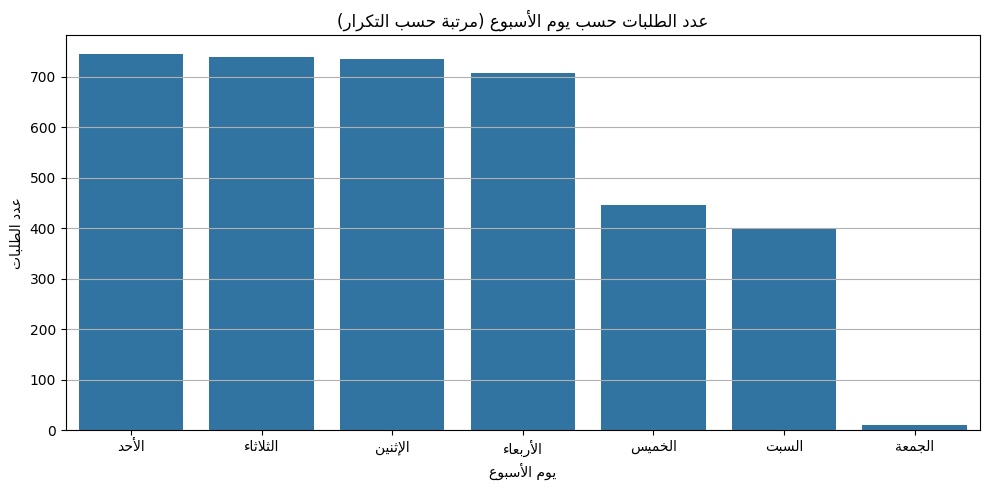

In [44]:
weekday_order = dataframe['يوم الأسبوع'].value_counts().index.tolist()
reshaped_order = [reshape_arabic(day) for day in weekday_order]

dataframe['يوم الأسبوع (عرض)'] = dataframe['يوم الأسبوع'].apply(reshape_arabic)

plt.figure(figsize=(10, 5))
sns.countplot(data=dataframe, x='يوم الأسبوع (عرض)', order=reshaped_order)
plt.title(reshape_arabic('عدد الطلبات حسب يوم الأسبوع (مرتبة حسب التكرار)'))
plt.xlabel(reshape_arabic('يوم الأسبوع'))
plt.ylabel(reshape_arabic('عدد الطلبات'))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [45]:
dataframe.columns

Index(['البلدية', 'الغرض', 'نوع سند الملكية', 'فئة مدة صلاحية الرخصة',
       'تاريخ تقديم الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب',
       'يوم الطلب', 'يوم الأسبوع', 'يوم الأسبوع (عرض)'],
      dtype='object')

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\

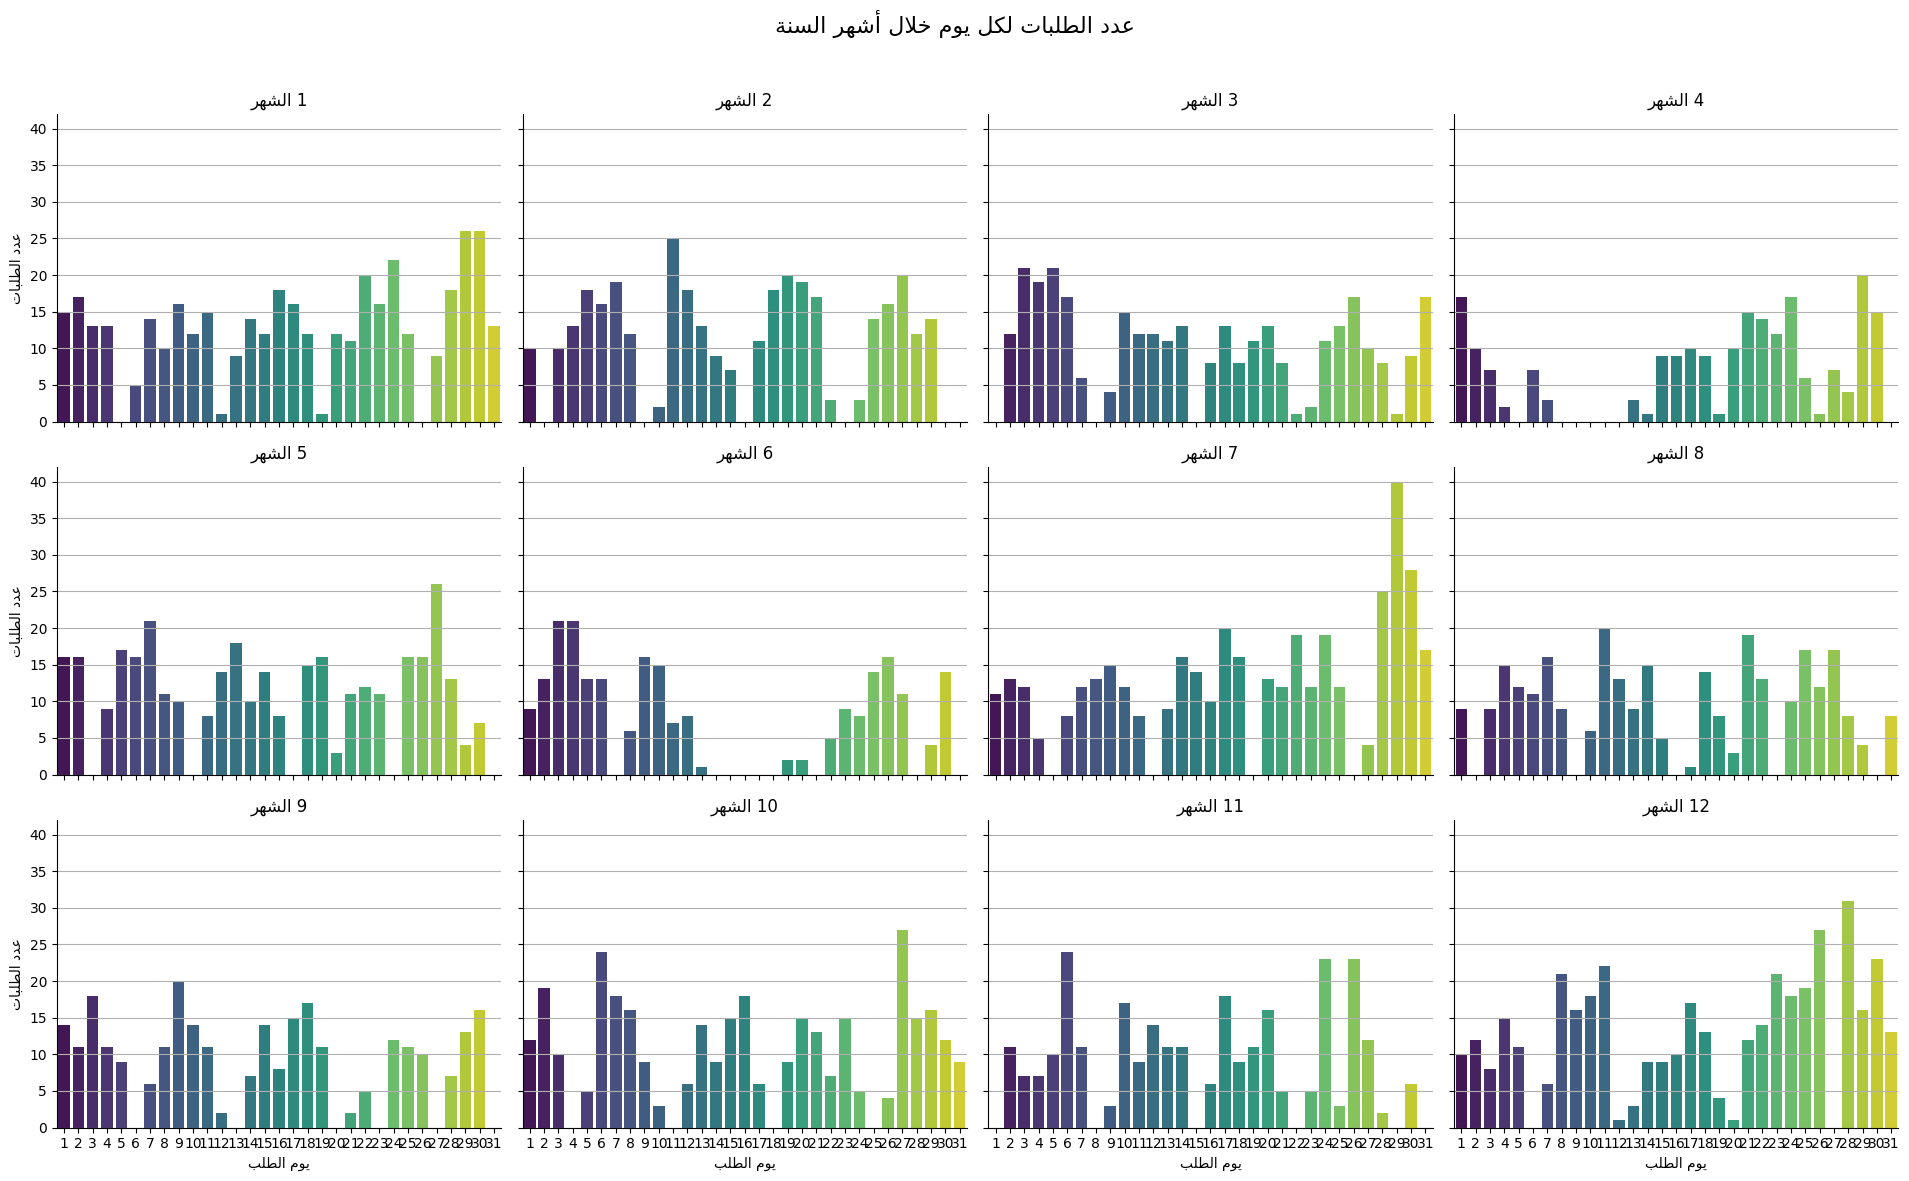

In [46]:
g = sns.FacetGrid(dataframe, col='شهر الطلب', col_wrap=4, height=4, aspect=1.2)
g.map(sns.countplot, 'يوم الطلب', order=range(1, 32), palette='viridis')

for ax in g.axes.flat:
    ax.set_title(reshape_arabic('الشهر') + f" {int(ax.get_title().split('=')[1])}")
    ax.set_xlabel(reshape_arabic('يوم الطلب'))
    ax.set_ylabel(reshape_arabic('عدد الطلبات'))
    ax.grid(axis='y')

plt.suptitle(reshape_arabic('عدد الطلبات لكل يوم خلال أشهر السنة'), fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # لتجنب تغطية العنوان الرئيسي
plt.show()

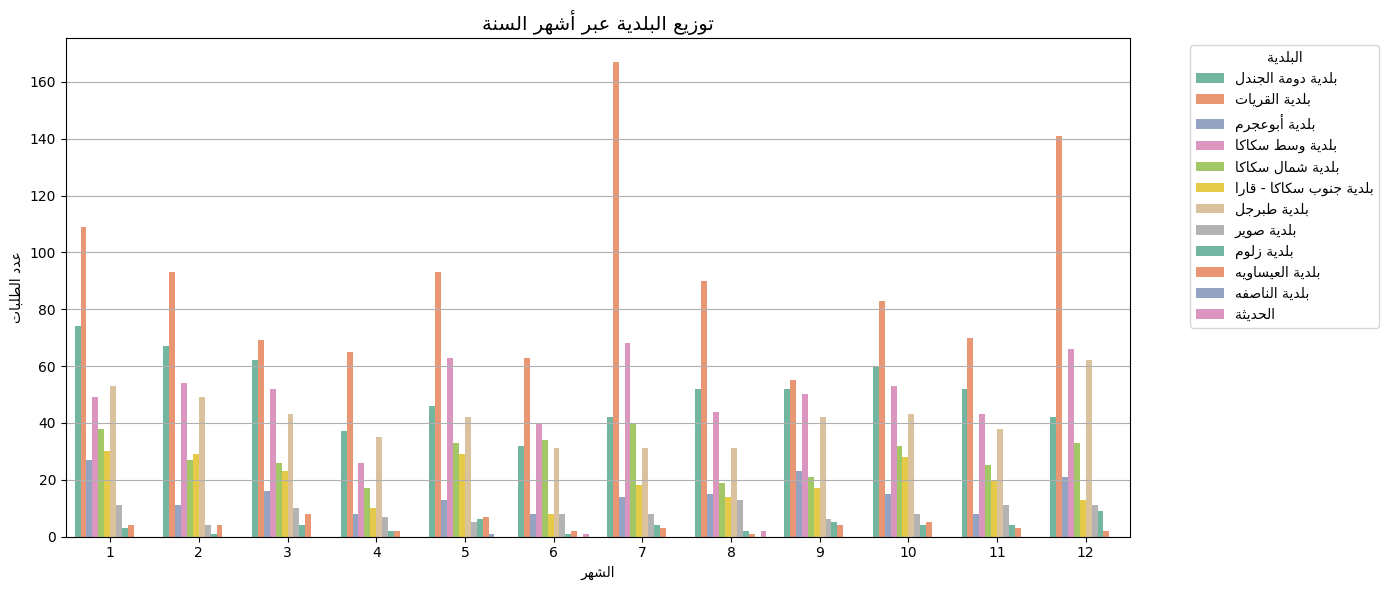

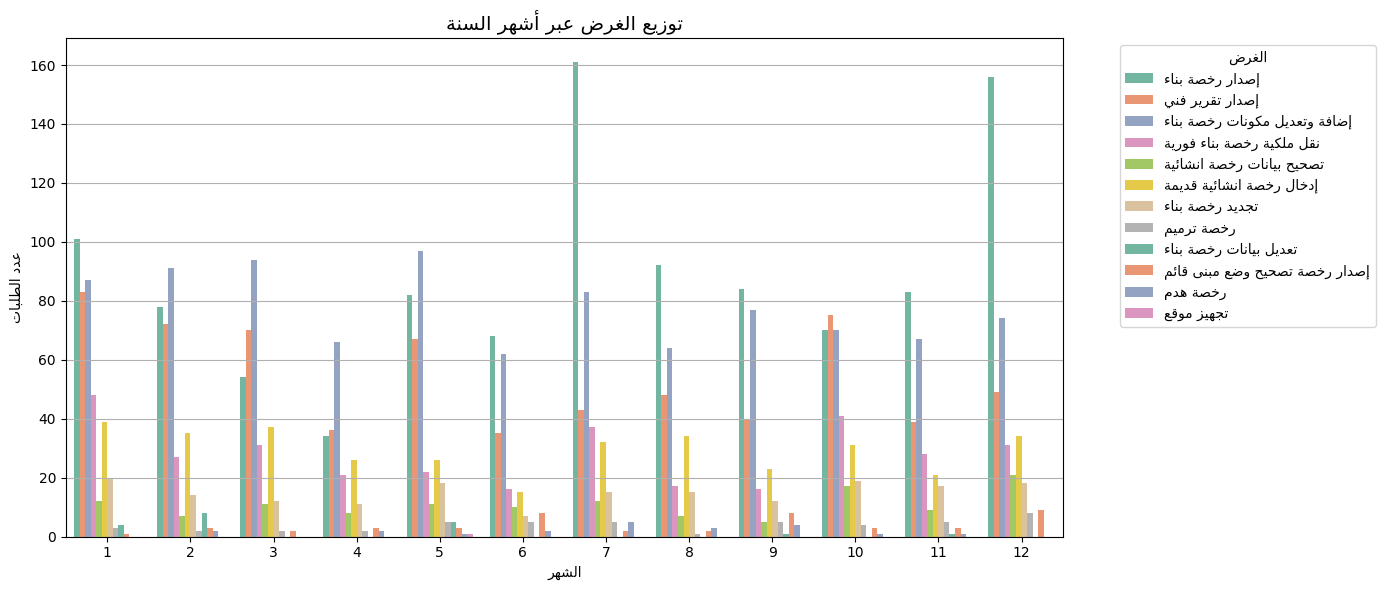

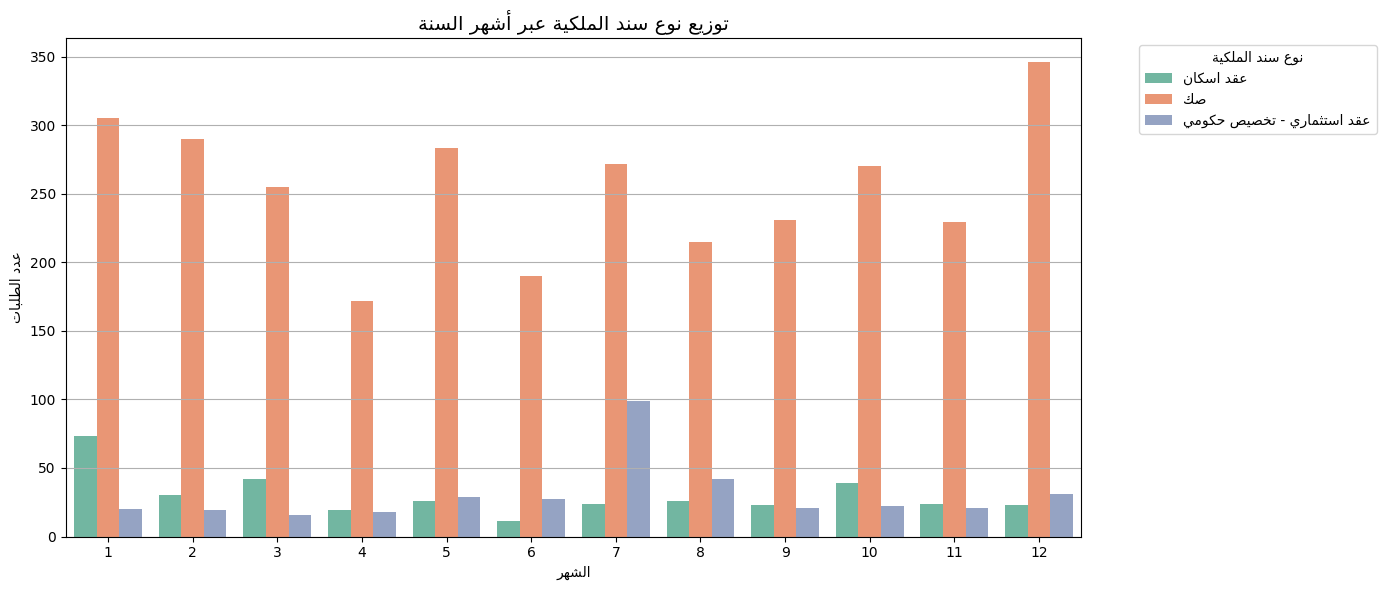

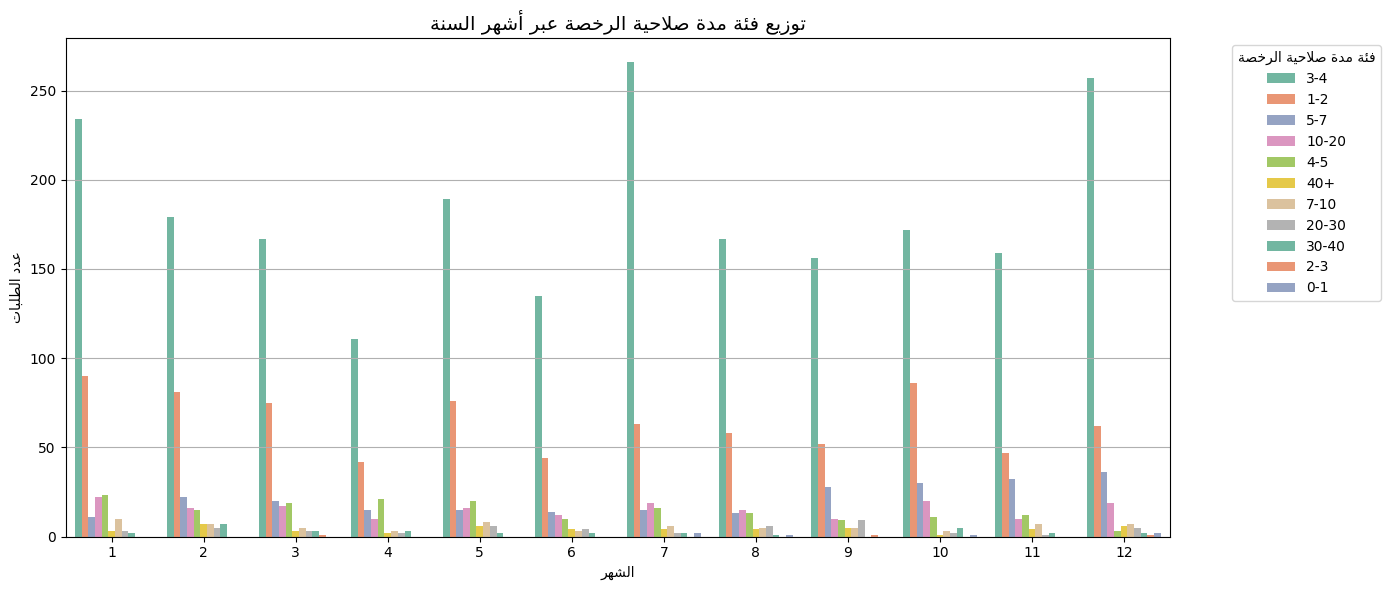

In [47]:

# Optional: limit number of categories per column to show (to avoid clutter)
# top_n = 5

for col in collection:
    categories = dataframe[col].value_counts().index
    df_filtered = dataframe[dataframe[col].isin(categories)].copy()

    df_filtered['category_reshaped'] = df_filtered[col].astype(str).apply(reshape_arabic)

    # Plot
    plt.figure(figsize=(14, 6))
    sns.countplot(
        data=df_filtered,
        x='شهر الطلب',
        hue='category_reshaped',
        palette='Set2'
    )

    plt.title(reshape_arabic(f'توزيع {col} عبر أشهر السنة'), fontsize=14)
    plt.xlabel(reshape_arabic('الشهر'))
    plt.ylabel(reshape_arabic('عدد الطلبات'))
    plt.legend(title=reshape_arabic(col), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


## 3. بناء النموذج التنبؤي
بعد الانتهاء من تحليل البيانات الزمنية واستخلاص الأنماط الموسمية، نقوم ببناء نموذج تنبؤ زمني متعدد الأبعاد يهدف إلى تقدير حجم الطلب على الرخص الإنشائية بشكل شهري وأسبوعي. كما يشمل النموذج التنبؤ بأنواع الطلبات والأنشطة الإنشائية المرتبطة بها. 

In [48]:
dataframe.columns

Index(['البلدية', 'الغرض', 'نوع سند الملكية', 'فئة مدة صلاحية الرخصة',
       'تاريخ تقديم الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب',
       'يوم الطلب', 'يوم الأسبوع', 'يوم الأسبوع (عرض)'],
      dtype='object')

In [49]:
dataframe.sample()

,البلدية,الغرض,نوع سند الملكية,فئة مدة صلاحية الرخصة,تاريخ تقديم الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع,يوم الأسبوع (عرض)
1177,بلدية جنوب سكاكا - قارا,تصحيح بيانات رخصة انشائية,صك,3-4,2024-07-20 18:59:22,2024,7,29,20,السبت,ﺖﺒﺴﻟﺍ


In [50]:
columns_needed

['البلدية',
 'الغرض',
 'نوع سند الملكية',
 'فئة مدة صلاحية الرخصة',
 'تاريخ تقديم الطلب',
 'سنة الطلب',
 'شهر الطلب',
 'أسبوع الطلب',
 'يوم الطلب',
 'يوم الأسبوع']

In [51]:
dataframe[dataframe.columns[:-1]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3783 entries, 0 to 3785
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   البلدية                3783 non-null   object        
 1   الغرض                  3783 non-null   object        
 2   نوع سند الملكية        3783 non-null   object        
 3   فئة مدة صلاحية الرخصة  3783 non-null   object        
 4   تاريخ تقديم الطلب      3783 non-null   datetime64[ns]
 5   سنة الطلب              3783 non-null   int32         
 6   شهر الطلب              3783 non-null   int32         
 7   أسبوع الطلب            3783 non-null   UInt32        
 8   يوم الطلب              3783 non-null   int32         
 9   يوم الأسبوع            3783 non-null   object        
dtypes: UInt32(1), datetime64[ns](1), int32(3), object(5)
memory usage: 269.7+ KB


In [52]:


def encode_and_save_encoders(df, columns, encoder_path="label_encoders.pkl"):
    """
    Encodes categorical columns using LabelEncoder and saves the encoders.
    
    Parameters:
        df: DataFrame to encode
        columns: List of column names to encode
        encoder_path: Path to save the encoder dictionary
    
    Returns:
        Encoded DataFrame
    """
    encoders = {}
    
    for col in columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            encoders[col] = le  # Save encoder for later use
    
    # Save all encoders to disk
    joblib.dump(encoders, encoder_path)
    print(f"✅ Encoders saved to {encoder_path}")
    
    return df


In [53]:
dataframe = encode_and_save_encoders(dataframe, columns_needed)

dataframe.sample()

✅ Encoders saved to label_encoders.pkl


C:\Users\USER\AppData\Local\Temp\ipykernel_3844\1569239872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\USER\AppData\Local\Temp\ipykernel_3844\1569239872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\USER\AppData\Local\Temp\ipykernel_3844\1569239872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,البلدية,الغرض,نوع سند الملكية,فئة مدة صلاحية الرخصة,تاريخ تقديم الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع,يوم الأسبوع (عرض)
2915,8,2,0,5,2024-09-28 20:34:23,2024,9,39,28,6,ﺖﺒﺴﻟﺍ


In [54]:
dataframe

,البلدية,الغرض,نوع سند الملكية,فئة مدة صلاحية الرخصة,تاريخ تقديم الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع,يوم الأسبوع (عرض)
0,5,4,0,5,2024-05-08 18:16:42,2024,5,19,8,1,ﺀﺎﻌﺑﺭﻷﺍ
1,10,3,0,5,2024-09-15 19:13:10,2024,9,37,15,0,ﺪﺣﻷﺍ
2,11,4,0,8,2024-05-22 10:39:57,2024,5,21,22,1,ﺀﺎﻌﺑﺭﻷﺍ
3,3,2,0,5,2024-07-18 00:32:18,2024,7,29,18,5,ﺲﻴﻤﺨﻟﺍ
4,10,0,0,5,2024-09-03 11:27:17,2024,9,36,3,3,ﺀﺎﺛﻼﺜﻟﺍ
...,...,...,...,...,...,...,...,...,...,...,...
3781,11,11,1,5,2024-03-06 12:24:17,2024,3,10,6,1,ﺀﺎﻌﺑﺭﻷﺍ
3782,3,1,0,1,2024-10-08 19:46:41,2024,10,41,8,3,ﺀﺎﺛﻼﺜﻟﺍ
3783,3,11,0,7,2024-10-21 10:28:57,2024,10,43,21,2,ﻦﻴﻨﺛﻹﺍ
3784,3,2,0,5,2024-07-11 19:18:08,2024,7,28,11,5,ﺲﻴﻤﺨﻟﺍ


In [55]:

df_daily = dataframe.groupby([
    'البلدية',
    'الغرض',
    'نوع سند الملكية',
    'سنة الطلب',
    'شهر الطلب',
    'أسبوع الطلب',
    'يوم الطلب',
    'يوم الأسبوع'
]).size().reset_index(name='عدد_الطلبات')

feature_cols = [
    'البلدية',
    'الغرض',
    'نوع سند الملكية',
    'سنة الطلب',
    'شهر الطلب',
    'أسبوع الطلب',
    'يوم الطلب',
    'يوم الأسبوع'
]

X = df_daily[feature_cols]
y = df_daily['عدد_الطلبات']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Absolute Error (MAE): 0.46


## 5. حفظ النماذج

In [56]:
joblib.dump(model, "xgb_permits_daily_model.pkl")
print("تم حفظ النموذج بنجاح في xgb_permits_daily_model.pkl")


تم حفظ النموذج بنجاح في xgb_permits_daily_model.pkl
